# Split-step Fourier beam propagation method (SSF-BPM)

For nonlinear propagation in linear or chi-3 media, according to the nonlinear Schrodinger equation (NLSE).





In [46]:
from google.colab import drive

import numpy as np
import scipy.io as sio
import time
from scipy import special
import matplotlib.pyplot as plt
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
from PIL import Image
import numpy as np

# Specify the path to your JPG image in Google Drive
# Update the path to point to your image file, for example:
# '/content/drive/MyDrive/your_image.jpg'
image_path = '/content/drive/MyDrive/Colab Notebooks/optical-resolution-charts-ps75p-usaf-pattern.jpg'

# Open the image using PIL and convert it to a NumPy array
image = Image.open(image_path)
image_array = np.array(image)

# Print out the type and shape to verify
print("Type:", type(image_array))
print("Shape:", image_array.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Type: <class 'numpy.ndarray'>
Shape: (1860, 1860, 3)


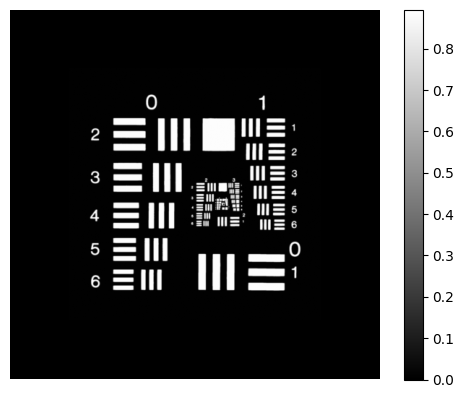

In [47]:
# Assuming image_array is already loaded and has shape (1860, 1860, 3)
# Convert the original image to a PIL Image and then to grayscale
gray_image = Image.fromarray(image_array).convert('L')

# Downsample the grayscale image to 350x350 pixels
gray_resized = gray_image.resize((350, 350), Image.BILINEAR)
gray_resized_array = np.array(gray_resized)

# Invert the image values (0 becomes 255 and vice versa)
inverted_array = 255 - gray_resized_array

# Create a zero-padded array of shape 512x512
# Zero padding will match the inverted background since inverted background is now 0.
padded_array = np.zeros((512, 512), dtype=inverted_array.dtype)

# Calculate the top-left coordinates for centering the 350x350 image in the 512x512 array
start = (512 - 350) // 2
padded_array[start:start+350, start:start+350] = inverted_array

# Normalize the padded array so values are between 0 and 1
norm_array = padded_array / 255.0

# Display the normalized image with a colorbar
# plt.figure(figsize=(6, 6))
plt.imshow(norm_array, cmap='gray')
plt.colorbar()
# plt.title("Inverted Grayscale: Downsampled, Zero-Padded, Normalized")
plt.axis('off')
plt.show()


#Setup the environment and define the computation window

In [48]:
# Computation domain discretization
Nz       = 40          # Number of steps in the z direction
Nx       = 512         # x-direction size of computational grid
Ny       = Nx          # x-direction size of computational grid. The computation domain is square

# Physical dimension of the computation space. Physical values are denoted with an underscore. The corresponding normalized value are written without underscore.
# We use SI units
Lx_ = 200e-6     # width of the computation window [m]
Ly_ = Lx_		           # height of the computation window [m]
Lz_ = 2e-6             # propagation distance [m]

n0_ = 1                # linear refractive index of background

lambda0_ = 0.5e-6      # free space wavelength [m]
delta_   = 1.0			   # normalization parameter (see documentation on SSF)
n2_      = 2.4e-19	   # nonlinear coefficient [m2/W]


#Setup the SSF-BPM variables


In [49]:
# Physical constants
mu0 = 4.0e-7 * np.pi    # free space magnetic permeability [Vs/Am]
c0  = 2.99792458e+8     # free space light speed [m/s]

epsilon0 = 1.0 / (mu0 * c0**2)         # free space permittivity [As/Vm]
eta0     = np.sqrt(mu0 / epsilon0)    # free space impedance [ohm]

# Derived parameters
n2_el   = n0_ * n2_ / (2 * eta0)        # nonlinear refractive index [m2/V2]
k0_     = 2 * np.pi / lambda0_       			# free space wavenumber [m-1]
k_      = n0_ * k0_                     # medium wavenumber [m-1]
lambda_ = lambda0_ / n0_                # medium wavelength [m]

# Variable that allows to switch between the paraxial (nonparaxial = 0) and nonparaxial (nonparaxial = 1) algorithm.
nonparaxial  = 1

# Normalization coefficients
# The equation can be normalized to a dimensionless form
# spatial normalization factor in the x-y plane
spatial_transverse_scale = 1/(k0_ * np.sqrt(2 * n0_ *  delta_))
# spatial normalization factor in the z direction
spatial_longitudinal_scale = 1/(delta_ * k0_)

scale_ratio = spatial_longitudinal_scale/spatial_transverse_scale  # = sqrt(2*n0_/delta_)
# normalization factor for the electric field
field_scale = np.sqrt(delta_ / n2_el);

# ************* Normalized parameters *************
Lx = Lx_ / spatial_transverse_scale                # normalized model width
Ly = Ly_ / spatial_transverse_scale                # normalized model height
Lz = Lz_ / spatial_longitudinal_scale              # normalized propagation distance
k  = 2*np.pi * spatial_transverse_scale / lambda_  # normalized light k-vector

# ************ Numeric model parameters ***********
dx_ = Lx_/Nx                                                                # normalized discretization step in x
dx  = Lx/Nx                                                                 # discretization step in x
x_  = dx_ * np.arange(-Nx/2,Nx/2,1)                                         # x dimension vector
x   = dx  * np.arange(-Nx/2,Nx/2,1)                                         # normalized x dimension vector
dkx = 2*np.pi/Lx                                                            # discretization in the spatial spectral domain along the y direction
kx  = dkx * np.concatenate((np.arange(0,Nx/2,1),np.arange(-Nx/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

# We do the same in the y and z direction
dy_ = Ly_/Ny                                                                # normalized discretization step in x
dy  = Ly/Ny                                                                 # discretization step in x
y_  = dy_ * np.arange(-Ny/2,Ny/2,1)                                         # x dimension vector
y   = dy  * np.arange(-Ny/2,Ny/2,1)                                         # normalized x dimension vector
dky = 2*np.pi/Ly                                                            # discretization in the spatial spectral domain along the y direction
ky  = dky * np.concatenate((np.arange(0,Ny/2,1),np.arange(-Ny/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

dz  = Lz/Nz
dz_ = Lz_/Nz
z   = dz * np.arange(1,Nz+1,1)
z_  = dz_* np.arange(1,Nz+1,1)

# Here we create the spatial computation grid (physical and normalized)
[X_, Y_]    = np.meshgrid(x_, y_)
[Xz_, Z_]   = np.meshgrid(x_, z_)
[X, Y]      = np.meshgrid(x, y)
[Xz, Z]     = np.meshgrid(x, z)

# The same for the spatial frequencies domain
[Kx, Ky]    = np.meshgrid(kx, ky)

K2 = np.multiply(Kx,Kx) + np.multiply(Ky,Ky) # Here we define some variable so that we don't need to compute them again and again

#Propagation routine

In [50]:
# u is our input field
u = norm_array


# absorbing_boundary=np.exp(-((X_ / (0.9*Lx_/(2*np.sqrt(np.log(2)))) )**20 + (Y_ / (0.9*Ly_/(2*np.sqrt(np.log(2)))) )**20))

# We declare this variable to monitor propagation (in the y-z plane)
fields=np.array(np.zeros((Nx,Ny,Nz)), dtype=complex)

nonlinearity=0

# Assign the first step input value to be your input field
u0 = u

t_start = time.time()
count=0
for index_z in range(Nz):
  count=count+1
  if nonparaxial == 0:
    # paraxial
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz))			# First linear half step
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs((u1))**2 ))         # Nonlinear step
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz))			# Second linear step
  else:
    # Nonparaxial code
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 ))
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))


  u0 = u3#*absorbing_boundary

  fields[:,:,count-1]=u3

# Let's store the result in a variable with a more explicit name
output = u3
t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

time elapsed: 4.0981950759887695 seconds


#Display results

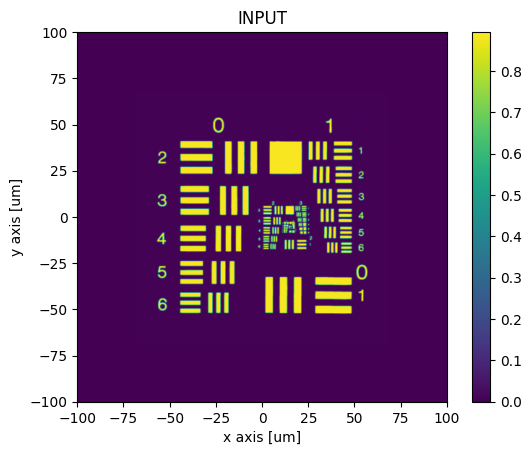

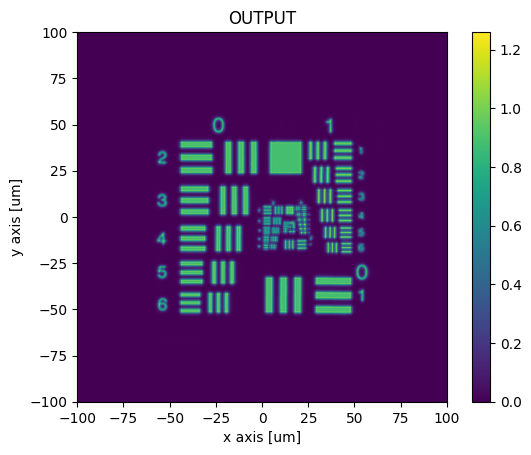

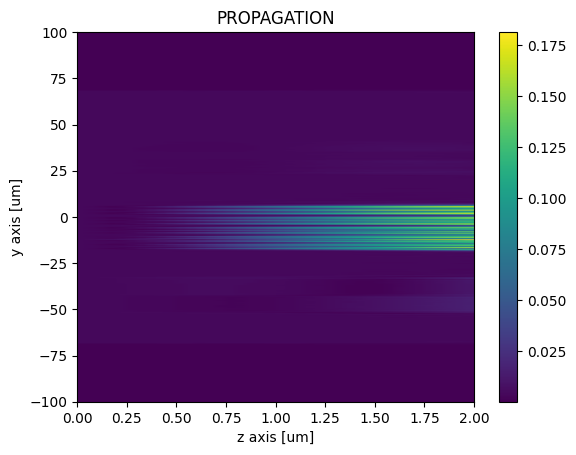

In [51]:
plt.imshow(np.abs(u),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('INPUT')
plt.show()

plt.imshow(np.abs(output),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('OUTPUT')
plt.show()

plt.imshow(np.squeeze(np.abs(fields[:,round(Ny/2),:])),aspect='auto',extent=[0,Lz_*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('y axis [um]')
plt.title('PROPAGATION')
plt.show()

Within 4*lambda, not much diffraction happened with the given physical sizes (fearures are very big). When we back-propagate the output field:

time elapsed: 2.7596771717071533 seconds


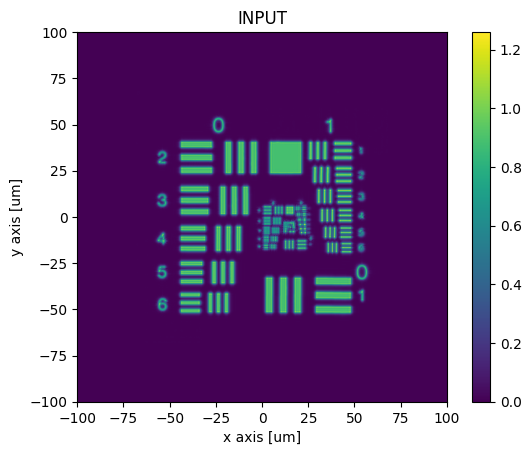

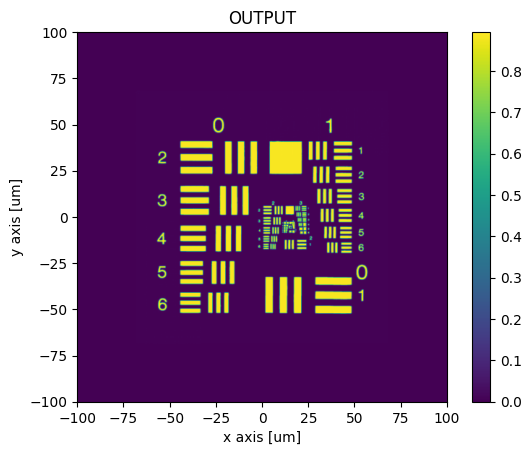

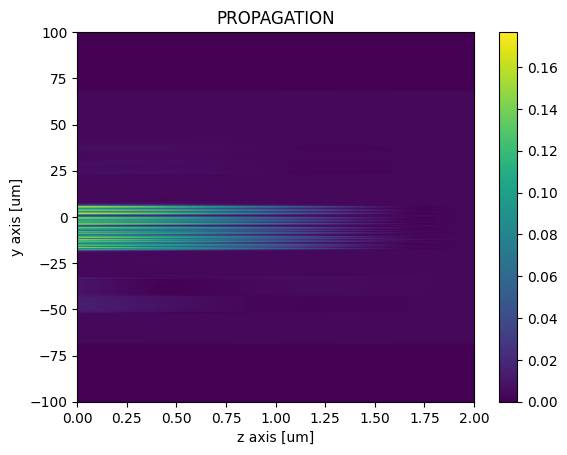

In [52]:
# u is our input field
u = output.conj()
# We declare this variable to monitor propagation (in the y-z plane)
fields=np.array(np.zeros((Nx,Ny,Nz)), dtype=complex)

# Assign the first step input value to be your input field
u0 = u

t_start = time.time()
count=0
for index_z in range(Nz):
  count=count+1
  if nonparaxial == 0:
    # paraxial
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz))			# First linear half step
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs((u1))**2 ))         # Nonlinear step
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz))			# Second linear step
  else:
    # Nonparaxial code
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 ))
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))


  u0 = u3#*absorbing_boundary

  fields[:,:,count-1]=u3

# Let's store the result in a variable with a more explicit name
output_back = u3
t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

plt.imshow(np.abs(u),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('INPUT')
plt.show()

plt.imshow(np.abs(output_back),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('OUTPUT')
plt.show()

plt.imshow(np.squeeze(np.abs(fields[:,round(Ny/2),:])),aspect='auto',extent=[0,Lz_*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('y axis [um]')
plt.title('PROPAGATION')
plt.show()

We reconstruct the input field without any loss of information! Now let's see for the case with sub-wavelength features.

time elapsed: 3.119286060333252 seconds


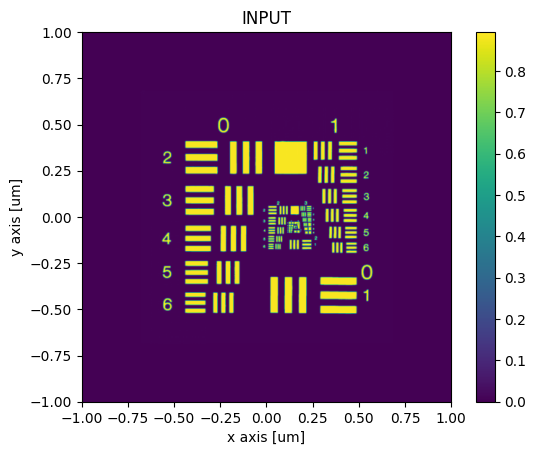

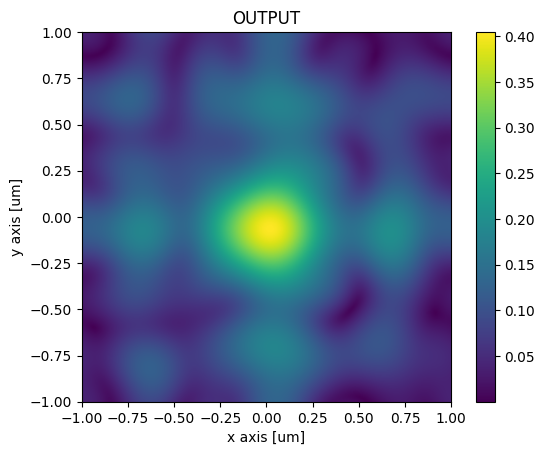

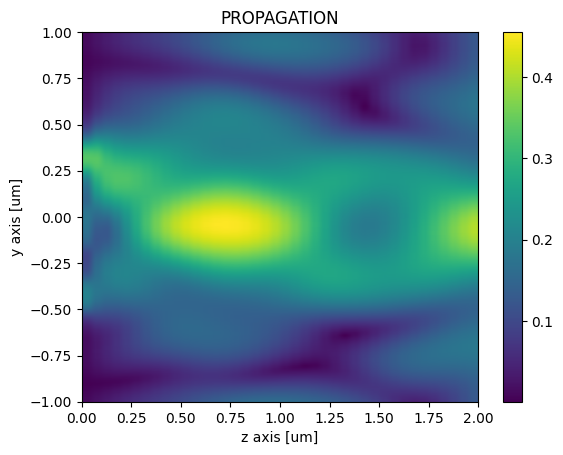

In [53]:
Lx_ = 2e-6     # width of the computation window [m]
Ly_ = Lx_		   # height of the computation window [m]
# ************* Normalized parameters *************
Lx = Lx_ / spatial_transverse_scale                # normalized model width
Ly = Ly_ / spatial_transverse_scale                # normalized model height
Lz = Lz_ / spatial_longitudinal_scale              # normalized propagation distance
k  = 2*np.pi * spatial_transverse_scale / lambda_  # normalized light k-vector

# ************ Numeric model parameters ***********
dx_ = Lx_/Nx                                                                # normalized discretization step in x
dx  = Lx/Nx                                                                 # discretization step in x
x_  = dx_ * np.arange(-Nx/2,Nx/2,1)                                         # x dimension vector
x   = dx  * np.arange(-Nx/2,Nx/2,1)                                         # normalized x dimension vector
dkx = 2*np.pi/Lx                                                            # discretization in the spatial spectral domain along the y direction
kx  = dkx * np.concatenate((np.arange(0,Nx/2,1),np.arange(-Nx/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

# We do the same in the y and z direction
dy_ = Ly_/Ny                                                                # normalized discretization step in x
dy  = Ly/Ny                                                                 # discretization step in x
y_  = dy_ * np.arange(-Ny/2,Ny/2,1)                                         # x dimension vector
y   = dy  * np.arange(-Ny/2,Ny/2,1)                                         # normalized x dimension vector
dky = 2*np.pi/Ly                                                            # discretization in the spatial spectral domain along the y direction
ky  = dky * np.concatenate((np.arange(0,Ny/2,1),np.arange(-Ny/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

dz  = Lz/Nz
dz_ = Lz_/Nz
z   = dz * np.arange(1,Nz+1,1)
z_  = dz_* np.arange(1,Nz+1,1)

# Here we create the spatial computation grid (physical and normalized)
[X_, Y_]    = np.meshgrid(x_, y_)
[Xz_, Z_]   = np.meshgrid(x_, z_)
[X, Y]      = np.meshgrid(x, y)
[Xz, Z]     = np.meshgrid(x, z)

# The same for the spatial frequencies domain
[Kx, Ky]    = np.meshgrid(kx, ky)

K2 = np.multiply(Kx,Kx) + np.multiply(Ky,Ky) # Here we define some variable so that we don't need to compute them again and again
# u is our input field
u = norm_array# rectangular_aperture*np.cos(Y_*2*np.pi/0.25e-6)             # <---### EDIT HERE ###

# We declare this variable to monitor propagation (in the y-z plane)
fields=np.array(np.zeros((Nx,Ny,Nz)), dtype=complex)

nonlinearity=0

# Assign the first step input value to be your input field
u0 = u

t_start = time.time()
count=0
for index_z in range(Nz):
  count=count+1
  if nonparaxial == 0:
    # paraxial
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz))			# First linear half step
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs((u1))**2 ))         # Nonlinear step
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz))			# Second linear step
  else:
    # Nonparaxial code
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 ))
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))


  u0 = u3#*absorbing_boundary

  fields[:,:,count-1]=u3

# Let's store the result in a variable with a more explicit name
output = u3
t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

plt.imshow(np.abs(u),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('INPUT')
plt.show()

plt.imshow(np.abs(output),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('OUTPUT')
plt.show()

plt.imshow(np.squeeze(np.abs(fields[:,round(Ny/2),:])),aspect='auto',extent=[0,Lz_*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('y axis [um]')
plt.title('PROPAGATION')
plt.show()

All the high frequency features are sub-wavelength and dampened before reaching to output plane. Now let us look back-propagation.

time elapsed: 3.6393725872039795 seconds


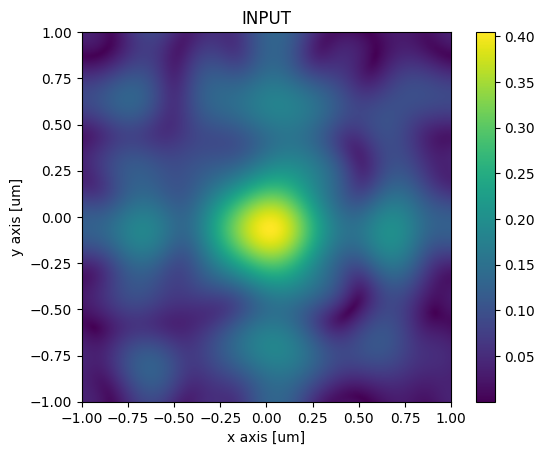

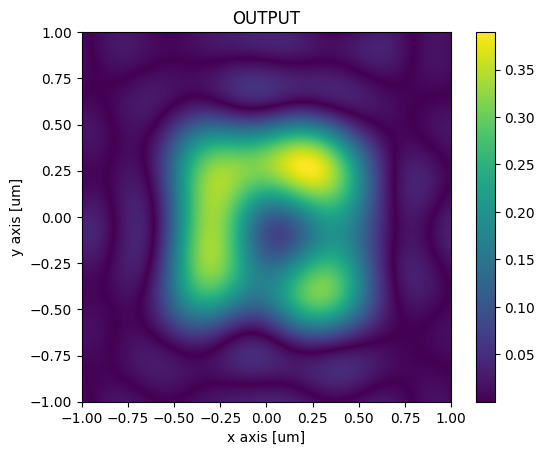

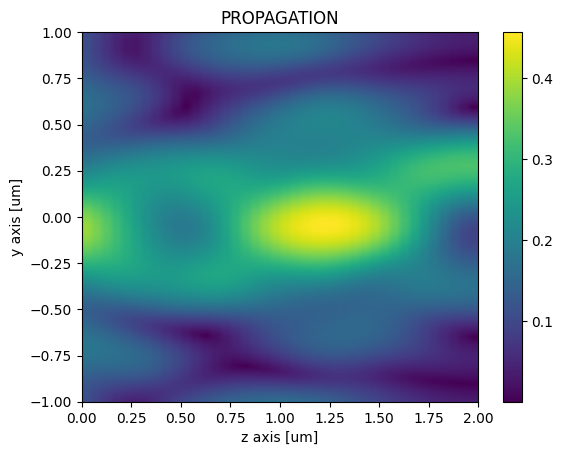

In [54]:
# u is our input field
u = output.conj()
# We declare this variable to monitor propagation (in the y-z plane)
fields=np.array(np.zeros((Nx,Ny,Nz)), dtype=complex)

# Assign the first step input value to be your input field
u0 = u

t_start = time.time()
count=0
for index_z in range(Nz):
  count=count+1
  if nonparaxial == 0:
    # paraxial
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz))			# First linear half step
    #u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs((u1))**2 ))         # Nonlinear step
    u3 = np.fft.ifft2(np.fft.fft2(u1) * np.exp(-1j * K2 * 0.5 * dz))			# Second linear step
  else:
    # Nonparaxial code
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))
    #u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 ))
    u3 = np.fft.ifft2(np.fft.fft2(u1) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))


  u0 = u3#*absorbing_boundary

  fields[:,:,count-1]=u3

# Let's store the result in a variable with a more explicit name
output_back = u3
t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

plt.imshow(np.abs(u),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('INPUT')
plt.show()

plt.imshow(np.abs(output_back),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('OUTPUT')
plt.show()

plt.imshow(np.squeeze(np.abs(fields[:,round(Ny/2),:])),aspect='auto',extent=[0,Lz_*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('y axis [um]')
plt.title('PROPAGATION')
plt.show()

Aparently all the information lost. Now let's look at the hybrid scenario.

time elapsed: 4.2363269329071045 seconds


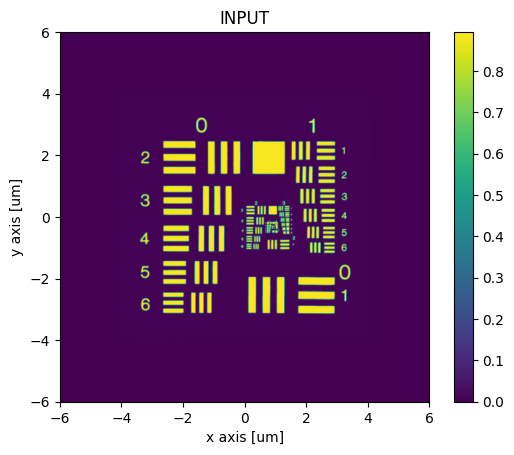

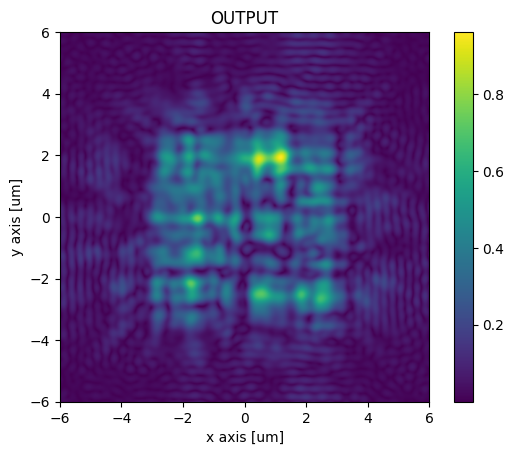

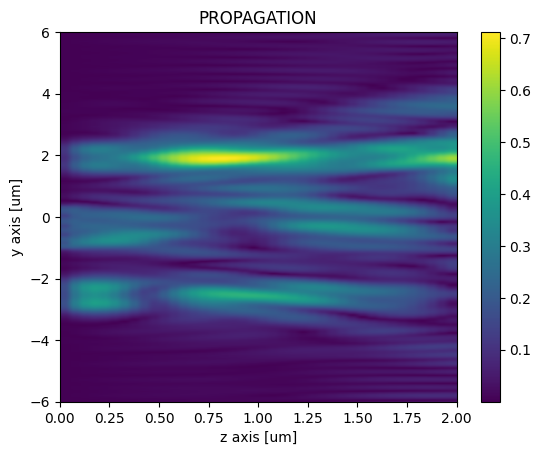

In [59]:
Lx_ = 12e-6     # width of the computation window [m]
Ly_ = Lx_		   # height of the computation window [m]
# ************* Normalized parameters *************
Lx = Lx_ / spatial_transverse_scale                # normalized model width
Ly = Ly_ / spatial_transverse_scale                # normalized model height
Lz = Lz_ / spatial_longitudinal_scale              # normalized propagation distance
k  = 2*np.pi * spatial_transverse_scale / lambda_  # normalized light k-vector

# ************ Numeric model parameters ***********
dx_ = Lx_/Nx                                                                # normalized discretization step in x
dx  = Lx/Nx                                                                 # discretization step in x
x_  = dx_ * np.arange(-Nx/2,Nx/2,1)                                         # x dimension vector
x   = dx  * np.arange(-Nx/2,Nx/2,1)                                         # normalized x dimension vector
dkx = 2*np.pi/Lx                                                            # discretization in the spatial spectral domain along the y direction
kx  = dkx * np.concatenate((np.arange(0,Nx/2,1),np.arange(-Nx/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

# We do the same in the y and z direction
dy_ = Ly_/Ny                                                                # normalized discretization step in x
dy  = Ly/Ny                                                                 # discretization step in x
y_  = dy_ * np.arange(-Ny/2,Ny/2,1)                                         # x dimension vector
y   = dy  * np.arange(-Ny/2,Ny/2,1)                                         # normalized x dimension vector
dky = 2*np.pi/Ly                                                            # discretization in the spatial spectral domain along the y direction
ky  = dky * np.concatenate((np.arange(0,Ny/2,1),np.arange(-Ny/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

dz  = Lz/Nz
dz_ = Lz_/Nz
z   = dz * np.arange(1,Nz+1,1)
z_  = dz_* np.arange(1,Nz+1,1)

# Here we create the spatial computation grid (physical and normalized)
[X_, Y_]    = np.meshgrid(x_, y_)
[Xz_, Z_]   = np.meshgrid(x_, z_)
[X, Y]      = np.meshgrid(x, y)
[Xz, Z]     = np.meshgrid(x, z)

# The same for the spatial frequencies domain
[Kx, Ky]    = np.meshgrid(kx, ky)

K2 = np.multiply(Kx,Kx) + np.multiply(Ky,Ky) # Here we define some variable so that we don't need to compute them again and again
# u is our input field
u = norm_array# rectangular_aperture*np.cos(Y_*2*np.pi/0.25e-6)             # <---### EDIT HERE ###

# We declare this variable to monitor propagation (in the y-z plane)
fields=np.array(np.zeros((Nx,Ny,Nz)), dtype=complex)

nonlinearity=0

# Assign the first step input value to be your input field
u0 = u

t_start = time.time()
count=0
for index_z in range(Nz):
  count=count+1
  if nonparaxial == 0:
    # paraxial
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz))			# First linear half step
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs((u1))**2 ))         # Nonlinear step
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz))			# Second linear step
  else:
    # Nonparaxial code
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))
    u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 ))
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))


  u0 = u3#*absorbing_boundary

  fields[:,:,count-1]=u3

# Let's store the result in a variable with a more explicit name
output = u3
t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

plt.imshow(np.abs(u),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('INPUT')
plt.show()

plt.imshow(np.abs(output),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('OUTPUT')
plt.show()

plt.imshow(np.squeeze(np.abs(fields[:,round(Ny/2),:])),aspect='auto',extent=[0,Lz_*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('y axis [um]')
plt.title('PROPAGATION')
plt.show()


From the outputs above, it is a bit hard to assess which part of information is lost and which part is just scrambled by diffraction. Let's check back-propgation to be sure:

time elapsed: 2.8486762046813965 seconds


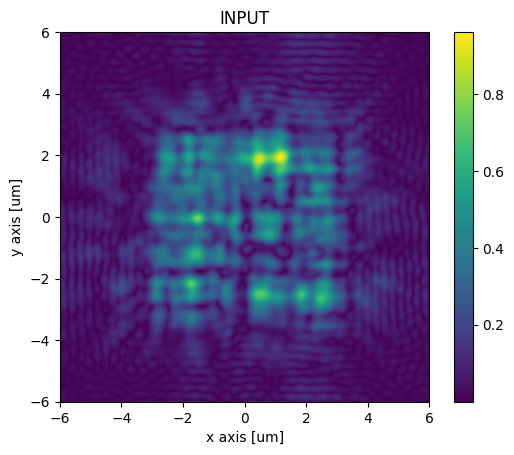

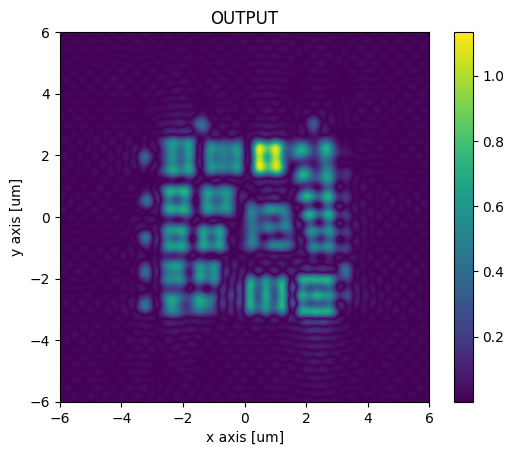

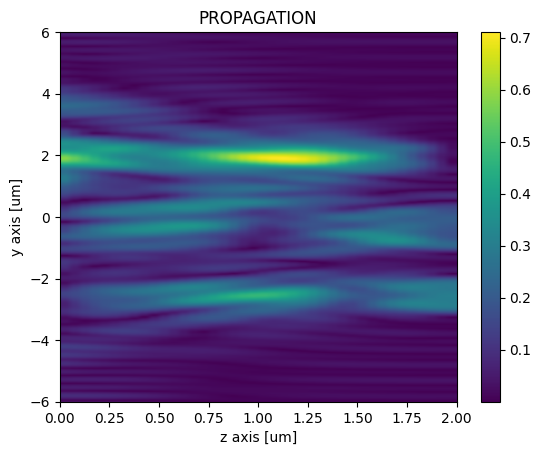

In [60]:
# u is our input field
u = output.conj()
# We declare this variable to monitor propagation (in the y-z plane)
fields=np.array(np.zeros((Nx,Ny,Nz)), dtype=complex)

# Assign the first step input value to be your input field
u0 = u

t_start = time.time()
count=0
for index_z in range(Nz):
  count=count+1
  if nonparaxial == 0:
    # paraxial
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz))			# First linear half step
    #u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs((u1))**2 ))         # Nonlinear step
    u3 = np.fft.ifft2(np.fft.fft2(u1) * np.exp(-1j * K2 * 0.5 * dz))			# Second linear step
  else:
    # Nonparaxial code
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))
    #u2 = u1 * np.exp(1j * dz * (nonlinearity * np.abs(u1)**2 ))
    u3 = np.fft.ifft2(np.fft.fft2(u1) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.emath.sqrt(k**2 - K2))))


  u0 = u3#*absorbing_boundary

  fields[:,:,count-1]=u3

# Let's store the result in a variable with a more explicit name
output_back = u3
t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

plt.imshow(np.abs(u),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('INPUT')
plt.show()

plt.imshow(np.abs(output_back),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.title('OUTPUT')
plt.show()

plt.imshow(np.squeeze(np.abs(fields[:,round(Ny/2),:])),aspect='auto',extent=[0,Lz_*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('z axis [um]')
plt.ylabel('y axis [um]')
plt.title('PROPAGATION')
plt.show()

We see that some of the low-frequency features are recongnizable (for the lines with the highest period, the period can be calculated fairly accurately). The other features are lost. Overall the image is as if it is low-pass filtered. This is indeed the case as we see in the class, the response of diffraction kernel becomes similar to a low-pass filter for sub-wavelength frequencies.